In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [203]:
param_old = [-10.00667732,  52.1855012,   12.68195726,  58.66322846, -20.11819297]

def gauss(x, A, m, s):
    if s < 0:
        return 10000000000000000
    return A*np.exp(-(x-m)**2 / (2*s**2))

def poly(x, a, b, c, d, e):
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

def exp_dt(sig):
    """
    expected drift distance  as a function of sigma of the S2 signal (Zrms from kdst 2018 version)
    parameters from the ad-hoc fit
    """
    p = param_old
    dt = p[0] * sig**4 + p[1] * sig**3 + p[2]*sig**2 + p[3]*sig + p[4]
    return dt

In [12]:
def ndigit(j, n):
    j = str(j)
    while len(j) < n:
        j = '0' + j
    return j

In [13]:
kdstfiles = ['/Volumes/NEXT_data/IC_Data/kdst/7472/kdst_'+ndigit(i, 4)+'_7472_trigger1_v1.1.0_20190801_krbg.h5' for i in range(1000) ]

In [152]:
X = np.array([])
Y = np.array([])
ZS1 = np.array([])
Zrms = np.array([])
S2e = np.array([])
from random import random

for kdstfile in kdstfiles:
    if random() > 0.05:
        print(kdstfile)
    kdst = pd.HDFStore(kdstfile, 'r')
    newX = np.array(kdst['/DST/Events']['X'])
    newY = np.array(kdst['/DST/Events']['Y'])
    newZS1 = np.array(kdst['/DST/Events']['Z'])
    newZrms = np.array(kdst['/DST/Events']['Zrms'])
    newS2e = np.array(kdst['/DST/Events']['S2e'])
    ZS1 = np.append(ZS1, newZS1)
    Zrms = np.append(Zrms, newZrms)
    S2e = np.append(S2e, newS2e)
    X = np.append(X, newX)
    Y = np.append(Y, newY)
    kdst.close()

In [150]:
import h5py
from time import time
import itertools as it
from scipy.optimize import curve_fit

zlims = [100, 200, 300, 400, 510]
rlims = [50, 100, 150, 180]

def gauss(x, A, m, s):
    if s < 0:
        return 10000000000000000
    return A*np.exp(-(x-m)**2 / (2*s**2))

def load_maps_from_file(filename, show = True):
    f = h5py.File(filename, 'r')
    e0map = np.array(f['e0']['block0_values'])
    ltmap = np.array(f['lt']['block0_values'])
    # f['mapinfo']['index'][i] tells you what is stored is stored in f['mapinfo']['values'][i]
    bounds = ((f['mapinfo']['values'][0], f['mapinfo']['values'][1]), (f['mapinfo']['values'][2], f['mapinfo']['values'][3]))
    f.close()

    if show:
        plt.imshow(e0map, extent=[bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]], origin = 'lower')
        plt.colorbar()
        plt.title('E0')
        plt.show()

        plt.imshow(ltmap, extent=[bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]], origin = 'lower')
        plt.colorbar()
        plt.title('LT')
        plt.clim(5000, 10000)
        plt.show()
    
    return e0map, ltmap, bounds

def get_bin_from_xy(x, y, emap, bounds):
    lowerx, lowery = bounds[0][0], bounds[1][0]
    upperx, uppery = bounds[0][1], bounds[1][1]
    nbinsx = len(emap)
    nbinsy = len(emap[0])
    dbinx = (bounds[0][1] - bounds[0][0]) / nbinsx
    dbiny = (bounds[1][1] - bounds[1][0]) / nbinsy
    ix = min(floor((x - lowerx) / dbinx), nbinsx-1)
    iy = min(floor((y - lowery) / dbiny), nbinsy-1)
    return ix, iy

def correct_energies(emap, bounds, umask, xvals, yvals, zvals, energies, ltmap = None, show = True, vocal = False):
    if vocal:
        print('Correcting energies...')
    ecorrs = []
    xymask = (xvals > bounds[0][0]) & (xvals < bounds[0][1]) & (yvals > bounds[1][0]) & (yvals < bounds[1][1])
    tcorstart = time()
    masked_xvals, masked_yvals = xvals[umask & xymask], yvals[umask & xymask]
    masked_energies = energies[umask & xymask]
    ncorevents = len(masked_xvals)
    factor_default = emap[int(len(emap)/2)][int(len(emap)/2)]
    for e in range(ncorevents):
        if vocal and e % 10000 == 0:
            print(e, '/', len(xvals[umask & xymask]))
            if e > 0:
                print('Est remaining =', round((ncorevents - e)*(time() - tcorstart) / e, 1))
        x, y = masked_xvals[e], masked_yvals[e]
        ix, iy = get_bin_from_xy(x, y, emap, bounds)
        factor = emap[ix][iy]
        if factor == 0 or np.isnan(factor):
            factor = factor_default
        if ltmap is not None:
            ixlt, iylt = get_bin_from_xy(x, y, ltmap, bounds)
            lt = ltmap[ixlt][iylt]
            z = zvals[umask & xymask][e]
            ltcorr = np.exp(z / lt)
            factor /= ltcorr
        ecorr = masked_energies[e] / factor
        ecorrs.append(ecorr)
    if show:
        plt.hist(ecorrs)
        plt.show()
    return np.array(ecorrs)

def plot_res_vs_zr(res_vs_zr):
    for rlim in rlims:
        res_vs_z = [ res_vs_zr[1000*zlim + rlim] for zlim in zlims ]
        plt.plot(zlims, res_vs_z, 'o', label = 'rlim = '+str(rlim)+' mm')
    plt.legend()
    plt.xlabel('Z upper limit (mm)')
    plt.ylabel('Resolution (%)')
    plt.show()
    print('Innermost resolution = ', round(res_vs_zr[1000*zlims[0] + rlims[0]], 2), '%')
    print('Outermost resolution = ', round(res_vs_zr[1000*zlims[-1] + rlims[-1]], 2), '%')

def fit_res_vs_xy(energies, emap, bounds, umask, xvals, yvals, zvals, show = True, zcut = 510):
    res_vs_xy = np.zeros((len(xbins),len(ybins)))
    xymask = (xvals > bounds[0][0]) & (xvals < bounds[0][1]) & (yvals > bounds[1][0]) & (yvals < bounds[1][1])
    masked_xvals, masked_yvals, masked_zvals = xvals[umask & xymask], yvals[umask & xymask], zvals[umask & xymask]
    min_nevents = 20
    
    for i, j in it.product(range(len(xbins)), range(len(ybins))):
        xbin = xbins[i]
        ybin = ybins[j]
    
        fidmask = (masked_zvals < zcut) & (masked_xvals > xbin[0]) & (masked_xvals < xbin[1]) & (masked_yvals > ybin[0]) & (masked_yvals < ybin[1]) #((masked_xvals**2 + masked_yvals**2) < rlim**2) & (masked_zvals < zlim)
        nevents = len(energies[fidmask])

        if nevents < min_nevents:
            resolution = np.nan
        else:
                        
            h = plt.hist(energies[fidmask], range=(0.85, 1.15), bins = 30)

            xdata = (h[1][:-1] + h[1][1:]) / 2
            ydata = h[0]

            (A0, m0, s0) = (np.max(ydata), 1, np.std(energies[fidmask]))

            try:
                popt, pcov = curve_fit(gauss, xdata, ydata, p0 = (A0, m0, s0))
                fitgauss = gauss(xdata, *popt)

                FWHM = 2.355 * popt[2]
                mean = popt[1]
                resolution = 100 * FWHM / mean
            except:
                resolution = np.nan
                    
        res_vs_xy[i][j] = resolution

        if (xbin == xbins[int(len(xbins)/2)]).all() and (ybin == ybins[int(len(ybins)/2)]).all() and show:
            print('Fit a Gaussian with guess (A0, m0, s0) =', (A0, m0, s0))
            plt.plot(xdata, fitgauss)
            plt.title('Xbin = '+str(xbin)+'; Ybin = '+str(ybin)+'. Resolution = '+str(round(resolution, 1))+'%')
            plt.show()
        else:
            plt.close()
    
    return res_vs_xy

def fit_res_vs_zr(energies, emap, bounds, umask, xvals, yvals, zvals, show = True):
    res_vs_zr = {}
    xymask = (xvals > bounds[0][0]) & (xvals < bounds[0][1]) & (yvals > bounds[1][0]) & (yvals < bounds[1][1])
    masked_xvals, masked_yvals, masked_zvals = xvals[umask & xymask], yvals[umask & xymask], zvals[umask & xymask]

    for zlim, rlim in it.product(zlims, rlims):
    
        fidmask = ((masked_xvals**2 + masked_yvals**2) < rlim**2) & (masked_zvals < zlim)
        h = plt.hist(energies[fidmask], range=(0.85, 1.15), bins = 30)

        xdata = (h[1][:-1] + h[1][1:]) / 2
        ydata = h[0]

        (A0, m0, s0) = (np.max(ydata), 1, np.std(energies[fidmask]))
        
        popt, pcov = curve_fit(gauss, xdata, ydata, p0 = (A0, m0, s0))
        fitgauss = gauss(xdata, *popt)

        FWHM = 2.355 * popt[2]
        mean = popt[1]
        resolution = 100 * FWHM / mean

        res_vs_zr[zlim*1000+rlim] = resolution

        if zlim == zlims[0] and rlim == rlims[0] and show:
            print('Fit a Gaussian with guess (A0, m0, s0) =', (A0, m0, s0))
            plt.plot(xdata, fitgauss)
            plt.title('Z < '+str(zlim)+'; R < '+str(rlim)+'. Resolution = '+str(round(resolution, 1))+'%')
            plt.show()
        else:
            plt.close()
    
    return res_vs_zr

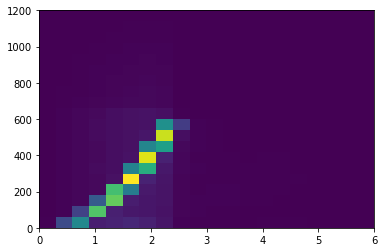

In [134]:
plt.hist2d(Zrms, ZS1, range=((0, 6),(0, 1200)), bins = 20)
plt.show()

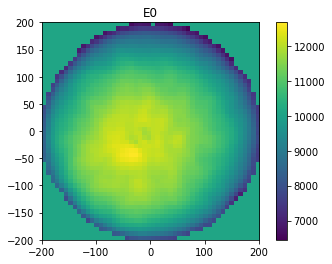

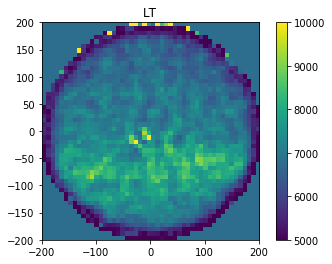

In [151]:
file_7472   = '/Volumes/NEXT_Data/IC_Data/st190819/maps/kr_emap_xy_50_50_r_7472_st190819.h5'

nomask = np.ones(len(S2e), dtype='bool')

# def correct_energies(emap, bounds, umask, xvals, yvals, zvals, energies, ltmap = None, show = True, vocal = False):

e0_7472, lt_7472, bounds_7472 = load_maps_from_file(file_7472)

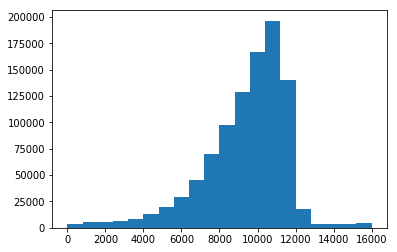

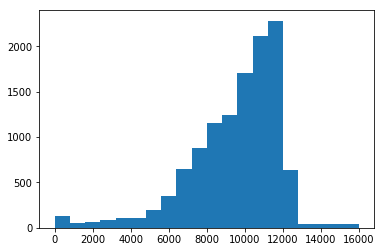

In [153]:
plt.hist(S2e, range = (0, 16000), bins = 20)
plt.show()

plt.hist(S2e[binmask], range = (0, 16000), bins = 20)
plt.show()

Ecut = (S2e > 2000) & (S2e < 14000)

Correcting energies using 7472
Correcting energies...
0 / 941199
10000 / 941199
Est remaining = 8154.7
20000 / 941199
Est remaining = 7274.3
30000 / 941199
Est remaining = 7115.5
40000 / 941199
Est remaining = 7288.9
50000 / 941199
Est remaining = 7117.7
60000 / 941199
Est remaining = 6849.1
70000 / 941199
Est remaining = 6630.9
80000 / 941199
Est remaining = 6463.3
90000 / 941199
Est remaining = 6313.0
100000 / 941199
Est remaining = 6176.3
110000 / 941199
Est remaining = 6050.4
120000 / 941199
Est remaining = 5932.8
130000 / 941199
Est remaining = 5878.6
140000 / 941199
Est remaining = 5775.9
150000 / 941199
Est remaining = 5682.9
160000 / 941199
Est remaining = 5589.8
170000 / 941199
Est remaining = 5495.5
180000 / 941199
Est remaining = 5402.0
190000 / 941199
Est remaining = 5313.6
200000 / 941199
Est remaining = 5233.1
210000 / 941199
Est remaining = 5153.8
220000 / 941199
Est remaining = 5076.2
230000 / 941199
Est remaining = 4996.0
240000 / 941199
Est remaining = 4915.5
250000 /

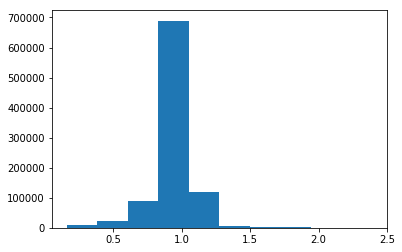

In [154]:
print('Correcting energies using 7472')
S2e_scaled = correct_energies(e0_7472, bounds_7472, Ecut, X, Y, ZS1, S2e, ltmap = lt_7472, vocal = True)

In [156]:
xymask = (X > bounds_7472[0][0]) & (X < bounds_7472[0][1]) & (Y > bounds_7472[1][0]) & (Y < bounds_7472[1][1])

In [ ]:
S2e_scaled = S2e_scaled * 41.5

In [178]:
med = np.median(S2e_scaled)
std = np.percentile(S2e_scaled, 50 + 68.27 / 2) - med

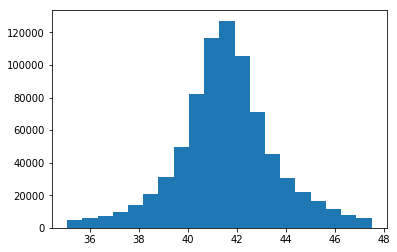

In [180]:
plt.hist(S2e_scaled, range = (med - 3 * std, med + 3 * std), bins = 20)
plt.show()

In [181]:
len(S2e[Ecut & xymask])
Krcut = (S2e_scaled > med - 3 * std) & (S2e_scaled < med + 3 * std)

941199

In [187]:
Zrms_nocut, ZS1_nocut = Zrms.copy(), ZS1.copy()
Zrms, ZS1 = Zrms[Ecut & xymask][Krcut], ZS1[Ecut & xymask][Krcut]

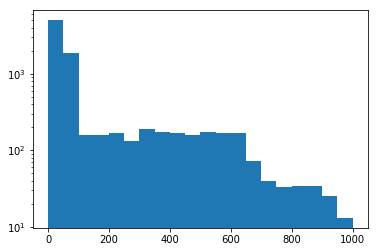

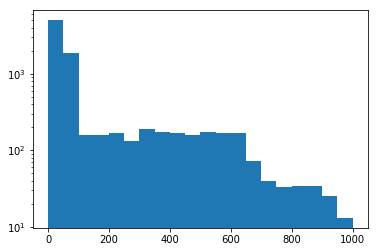

In [188]:
mybin = bins[11]
binmask = (Zrms > mybin[0]) & (Zrms < mybin[1])
testhist = ZS1[binmask]
plt.hist(testhist, range = (0, 1000), bins = 20)
plt.yscale('log')
plt.show()

mybin = bins[11]
testhist = ZS1[binmask]
plt.hist(testhist, range = (0, 1000), bins = 20)
plt.yscale('log')
plt.show()

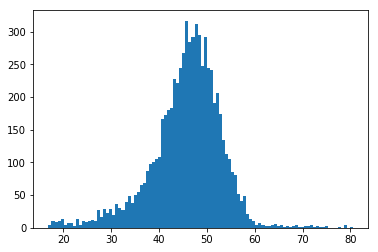

Median = 48.7
[288.77803953  46.9680422    5.61328948]
Gaussian center = 47.0


In [229]:
mytestbin = ZS1[(Zrms > mybin[0]) & (Zrms < mybin[1])]
A0 = max(ydata)
m0 = np.median(mytestbin)
s0 = m0 - np.percentile(mytestbin,50 - 68/2)
p0 = (A0, m0, s0)

h = plt.hist(mytestbin, range = (m0 - 4*s0, m0 + 4*s0), bins = 100)
plt.show()

hbins = np.array([h[1][:-1], h[1][1:]]).T
xdata = [ np.mean(hbin) for hbin in hbins ]
ydata = h[0]

print('Median =', round(np.median(mytestbin),1))

popt, pcov = curve_fit(gauss, xdata, ydata, p0 = (A0, m0, s0))
print(popt)

print('Gaussian center =', round(popt[1],1))

In [189]:
nbins = 41
rms_min, rms_max = 0.1, 2.3
binedges = np.linspace(rms_min, rms_max, nbins)
bin_starts = binedges[:-1]
bin_ends = binedges[1:]
bins = np.array([bin_starts, bin_ends]).T
bin_mids = np.array([np.mean(mybin) for mybin in bins])
means = np.array([np.mean(ZS1[(Zrms > mybin[0]) & (Zrms < mybin[1])]) for mybin in bins])
medians = np.array([np.median(ZS1[(Zrms > mybin[0]) & (Zrms < mybin[1])]) for mybin in bins])

stds = np.array([np.std(ZS1[(Zrms > mybin[0]) & (Zrms < mybin[1])]) for mybin in bins])

[0.1   0.155]


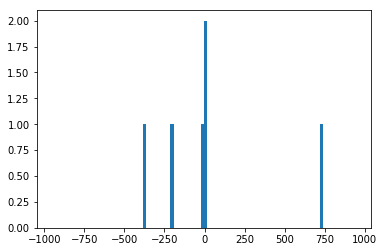

Median = -3.7
[10.38436884 -2.8768138   4.77248983]
Gaussian center = -2.9
[0.155 0.21 ]


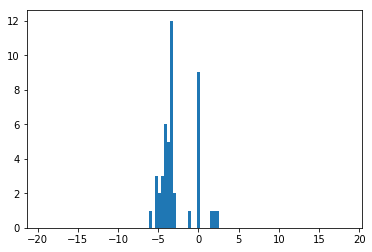

Median = -0.5
[ 8.58478238 -3.60179295  0.52765118]
Gaussian center = -3.6
[0.21  0.265]


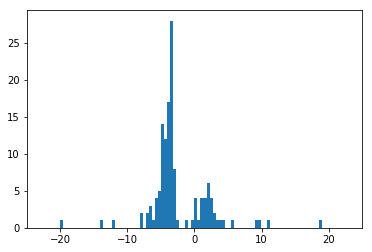

Median = -0.0
[21.10960949 -3.802204    0.762488  ]
Gaussian center = -3.8
[0.265 0.32 ]


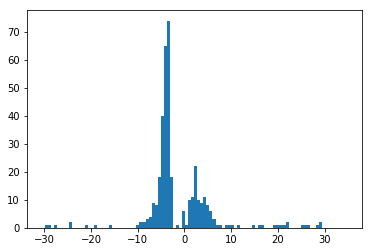

Median = 2.1
[75.04346365 -3.88801835  0.75986937]
Gaussian center = -3.9
[0.32  0.375]


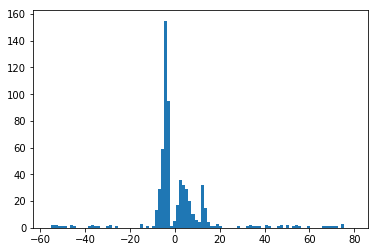

Median = 11.5
[156.91596947  -3.97019897   1.13989727]
Gaussian center = -4.0
[0.375 0.43 ]


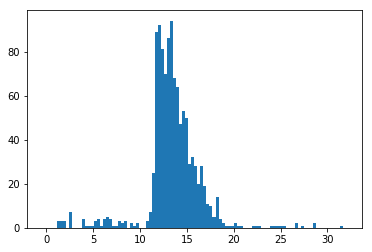

Median = 15.8
[84.94997392 13.21353866  1.51605568]
Gaussian center = 13.2
[0.43  0.485]


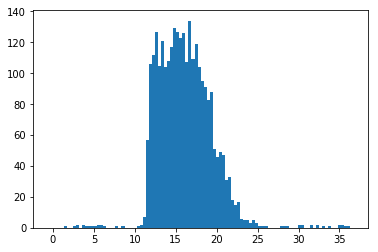

Median = 18.0
[133.71417645  15.73125966   3.1214166 ]
Gaussian center = 15.7
[0.485 0.54 ]


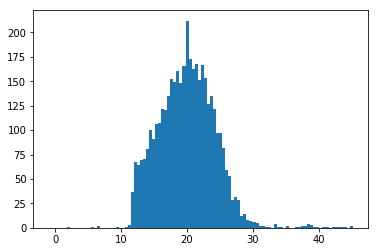

Median = 22.1
[175.42589785  19.89735398   4.36252042]
Gaussian center = 19.9
[0.54  0.595]


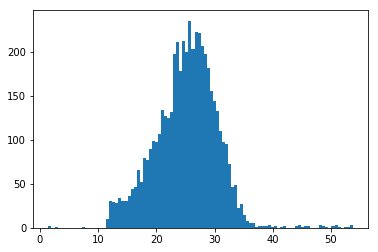

Median = 27.6
[212.5191279   25.68555758   4.79256768]
Gaussian center = 25.7
[0.595 0.65 ]


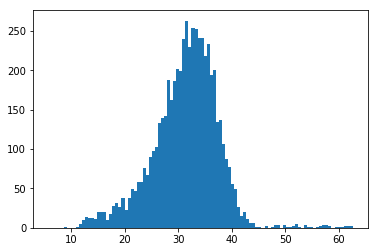

Median = 34.2
[246.30052479  32.27688352   5.0233291 ]
Gaussian center = 32.3
[0.65  0.705]


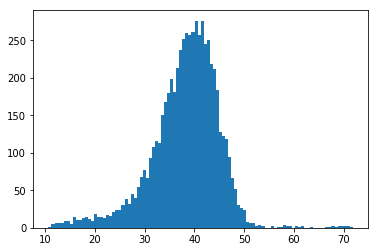

Median = 41.3
[266.86757084  39.44160267   5.37656466]
Gaussian center = 39.4
[0.705 0.76 ]


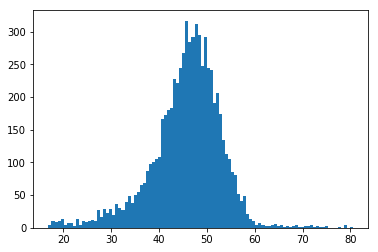

Median = 48.7
[288.77803953  46.9680422    5.61328948]
Gaussian center = 47.0
[0.76  0.815]


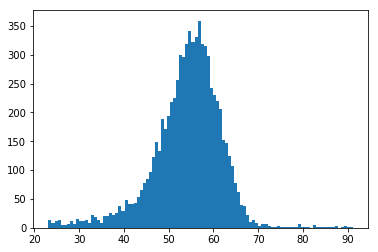

Median = 57.1
[328.20907851  55.4043509    5.91062155]
Gaussian center = 55.4
[0.815 0.87 ]


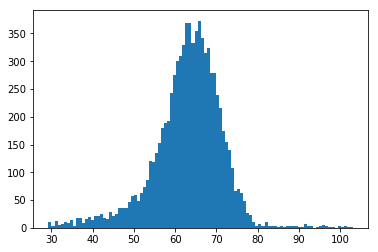

Median = 66.2
[356.72668384  64.36496592   6.3837924 ]
Gaussian center = 64.4
[0.87  0.925]


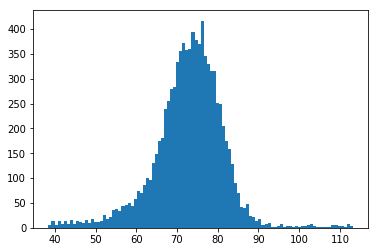

Median = 75.8
[387.73511209  73.92451375   6.6031302 ]
Gaussian center = 73.9
[0.925 0.98 ]


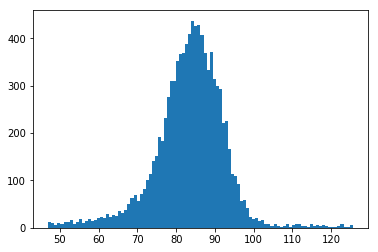

Median = 86.3
[418.37505927  84.48972548   6.92725119]
Gaussian center = 84.5
[0.98  1.035]


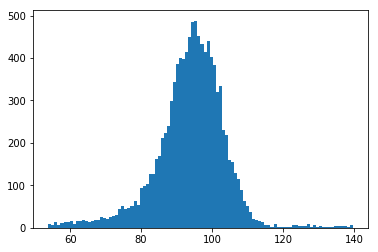

Median = 96.7
[462.21228489  95.16262149   7.39327169]
Gaussian center = 95.2
[1.035 1.09 ]


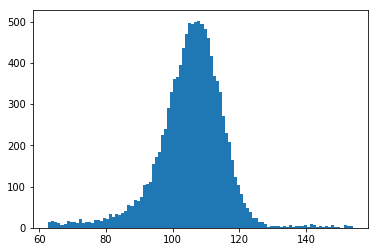

Median = 108.3
[496.55487613 106.67612238   7.77312438]
Gaussian center = 106.7
[1.09  1.145]


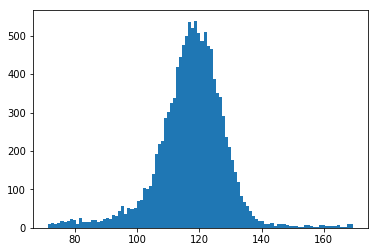

Median = 120.4
[523.84640508 118.54883092   8.33635975]
Gaussian center = 118.5
[1.145 1.2  ]


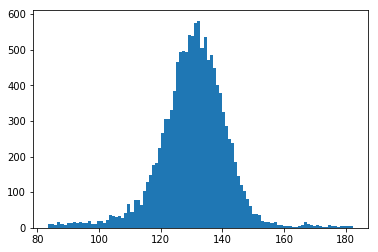

Median = 132.9
[548.77169319 131.37011495   8.85818696]
Gaussian center = 131.4
[1.2   1.255]


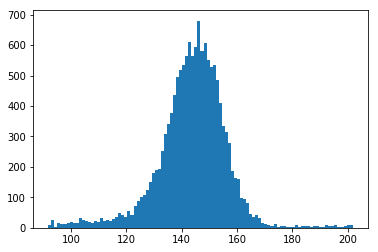

Median = 146.8
[618.13284932 145.13820268   9.37929035]
Gaussian center = 145.1
[1.255 1.31 ]


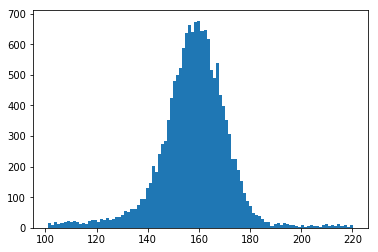

Median = 160.6
[661.41281596 159.05671726  10.26861348]
Gaussian center = 159.1
[1.31  1.365]


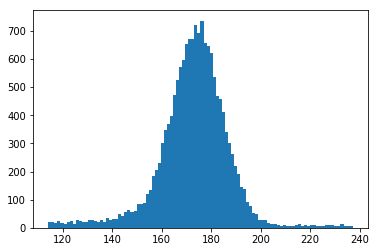

Median = 175.7
[695.55875571 174.08330615  10.44282578]
Gaussian center = 174.1
[1.365 1.42 ]


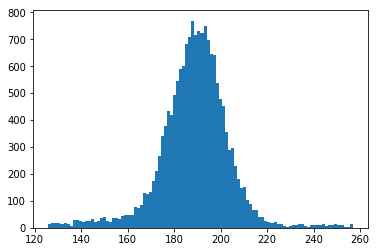

Median = 191.3
[737.67343437 189.71864036  11.19351089]
Gaussian center = 189.7
[1.42  1.475]


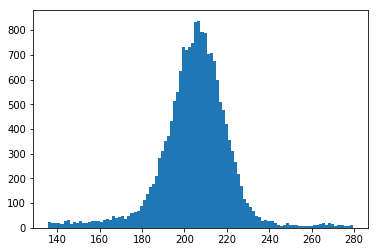

Median = 207.6
[797.32163665 206.22971566  11.99842345]
Gaussian center = 206.2
[1.475 1.53 ]


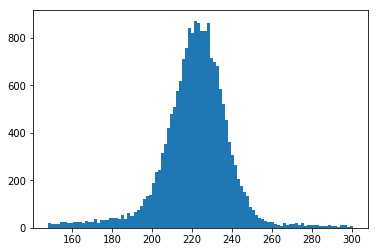

Median = 224.3
[853.84916084 223.15466419  12.52120216]
Gaussian center = 223.2
[1.53  1.585]


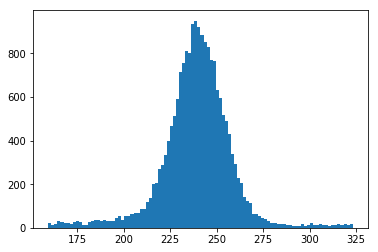

Median = 241.3
[898.7436934  240.27779598  13.23894351]
Gaussian center = 240.3
[1.585 1.64 ]


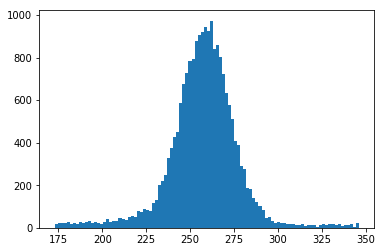

Median = 259.4
[935.79935418 258.5902895   14.23808081]
Gaussian center = 258.6
[1.64  1.695]


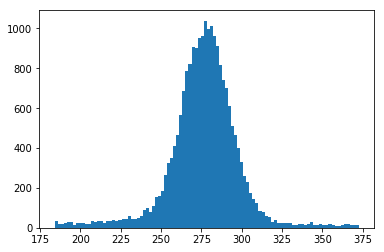

Median = 278.3
[1003.72384804  277.69533847   15.05037855]
Gaussian center = 277.7
[1.695 1.75 ]


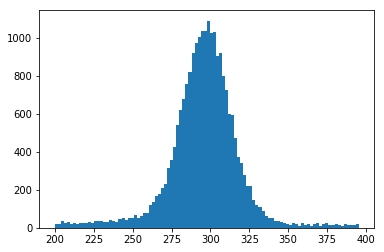

Median = 297.6
[1048.66625301  297.10664742   15.57876425]
Gaussian center = 297.1
[1.75  1.805]


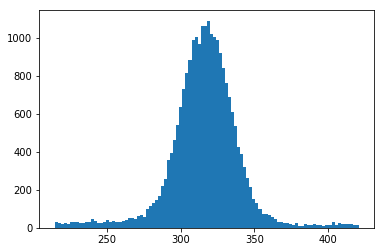

Median = 317.7
[1069.08004789  317.21043025   16.93767587]
Gaussian center = 317.2
[1.805 1.86 ]


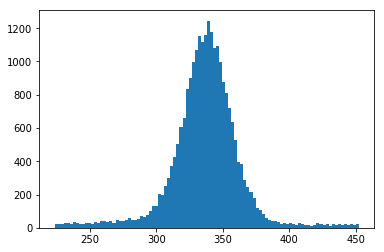

Median = 338.1
[1175.33455376  338.09461181   17.4387124 ]
Gaussian center = 338.1
[1.86  1.915]


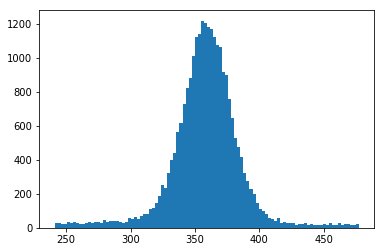

Median = 359.2
[1192.77025433  359.42043876   18.54645329]
Gaussian center = 359.4
[1.915 1.97 ]


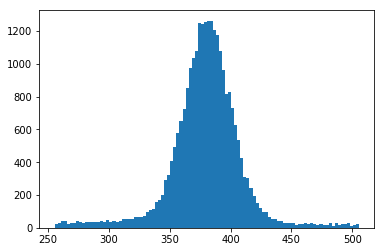

Median = 380.5
[1249.90484415  381.00162607   19.61187398]
Gaussian center = 381.0
[1.97  2.025]


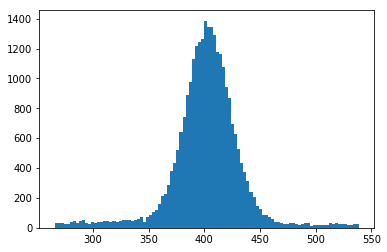

Median = 402.3
[1341.58866113  403.41477728   20.51938848]
Gaussian center = 403.4
[2.025 2.08 ]


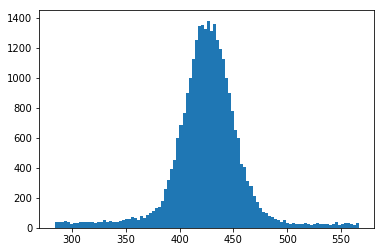

Median = 425.3
[1373.96982889  426.54693085   21.66419155]
Gaussian center = 426.5
[2.08  2.135]


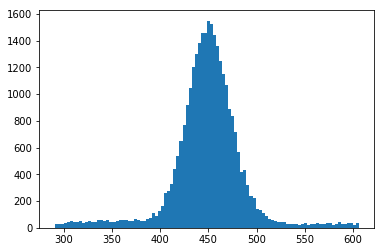

Median = 448.4
[1496.43086641  450.18287641   22.76350541]
Gaussian center = 450.2
[2.135 2.19 ]


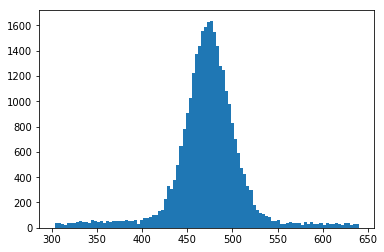

Median = 471.7
[1587.39417494  474.06975683   23.59634324]
Gaussian center = 474.1
[2.19  2.245]


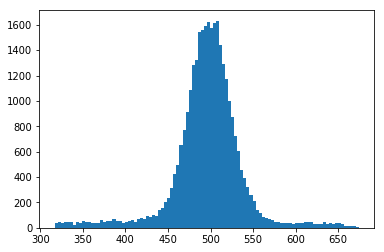

Median = 495.7
[1645.15693468  498.61434257   24.73627197]
Gaussian center = 498.6
[2.245 2.3  ]


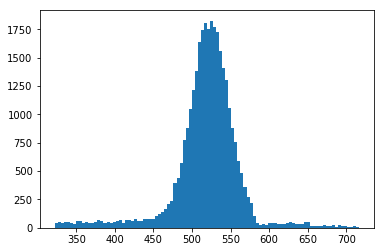

Median = 519.4
[1825.99535688  523.36371596   25.07173198]
Gaussian center = 523.4


In [230]:
fitcenters = []

for mybin in bins:
    print(mybin)
    mydata = ZS1[(Zrms > mybin[0]) & (Zrms < mybin[1])]
    m0 = np.median(mydata)
    s0 = m0 - np.percentile(mydata,50 - 68/2)

    h = plt.hist(mydata, range = (m0 - 4*s0, m0 + 4*s0), bins = 100)
    plt.show()

    hbins = np.array([h[1][:-1], h[1][1:]]).T
    xdata = [ np.mean(hbin) for hbin in hbins ]
    ydata = h[0]
    A0 = max(ydata)
    p0 = (A0, m0, s0)

    print('Median =', round(np.median(mydata),1))

    popt, pcov = curve_fit(gauss, xdata, ydata, p0 = (A0, m0, s0))
    print(popt)

    print('Gaussian center =', round(popt[1],1))
    
    fitcenters.append(popt[1])
    
fitcenters = np.array(fitcenters)

In [243]:
cut = bin_mids > 0.5

Med fit params:  [ -7.86012717  37.49369013  43.66355946  32.93310459 -11.04391177]
Mean fit params: [ -7.29458829  36.75343889  42.63965994  35.39066833 -14.00773813]


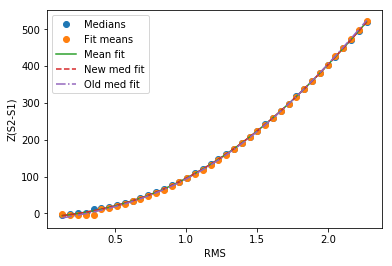

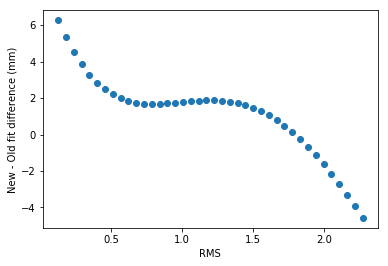

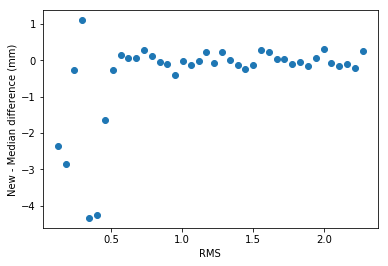

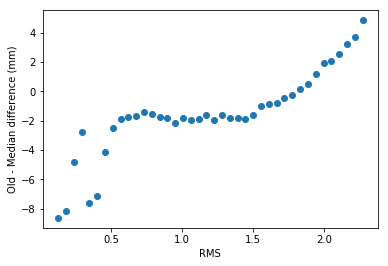

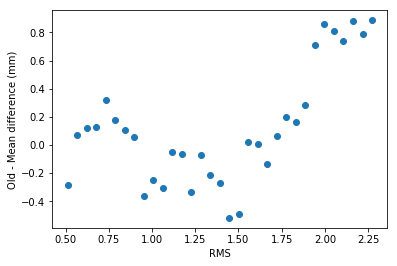

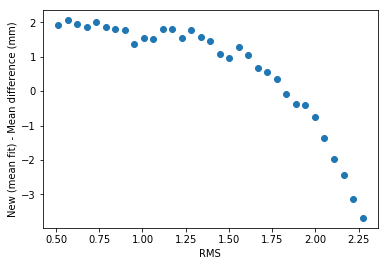

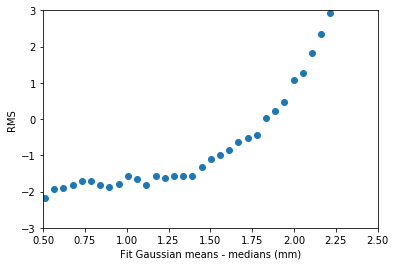

In [245]:
popt, pcov = curve_fit(poly, bin_mids[cut], medians[cut], p0 = param_old)
poptf, pcovf = curve_fit(poly, bin_mids[cut], fitcenters[cut], p0 = param_old)

print('Med fit params: ', popt)
print('Mean fit params:', poptf)

fitcurve = poly(bin_mids, *popt)
gaussfitcurve = poly(bin_mids, *popt)
oldcurve = poly(bin_mids, *param_old)

plt.plot(bin_mids, medians, 'o', label='Medians')
plt.plot(bin_mids, fitcenters, 'o', label='Fit means')
plt.plot(bin_mids, gaussfitcurve, '-', label = 'Mean fit')
plt.plot(bin_mids, fitcurve, '--', label='New med fit')
plt.plot(bin_mids, oldcurve, '-.', label='Old med fit')
plt.legend()
plt.xlabel('RMS')
plt.ylabel('Z(S2-S1)')
plt.show()

diff = fitcurve - oldcurve
plt.plot(bin_mids, diff, 'o')
plt.xlabel('RMS')
plt.ylabel('New - Old fit difference (mm)')
plt.show()

plt.plot(bin_mids, fitcurve - medians, 'o')
plt.xlabel('RMS')
plt.ylabel('New - Median difference (mm)')
plt.show()

plt.plot(bin_mids, oldcurve - medians, 'o')
plt.xlabel('RMS')
plt.ylabel('Old - Median difference (mm)')
plt.show()

plt.plot(bin_mids[cut], (oldcurve - fitcenters)[cut], 'o')
plt.xlabel('RMS')
plt.ylabel('Old - Mean difference (mm)')
plt.show()

plt.plot(bin_mids[cut], (gaussfitcurve - fitcenters)[cut], 'o')
plt.xlabel('RMS')
plt.ylabel('New (mean fit) - Mean difference (mm)')
plt.show()


plt.plot(bin_mids, fitcenters - medians, 'o')
plt.xlim(0.5, 2.5)
plt.ylim(-3, 3)
plt.xlabel('Fit Gaussian means - medians (mm)')
plt.ylabel('RMS')
plt.show()

In [191]:
popt

array([-8.23116853, 38.38909015, 45.16208082, 27.86952101, -8.04107085])

In [192]:
param_old

[-10.00667732, 52.1855012, 12.68195726, 58.66322846, -20.11819297]

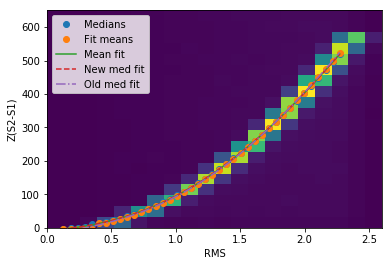

In [238]:
plt.hist2d(Zrms, ZS1, range=((0, 2.6),(0, 650)), bins = 20)
plt.plot(bin_mids, medians, 'o', label='Medians')
plt.plot(bin_mids, fitcenters, 'o', label='Fit means')
plt.plot(bin_mids, gaussfitcurve, '-', label = 'Mean fit')
plt.plot(bin_mids, fitcurve, '--', label='New med fit')
plt.plot(bin_mids, oldcurve, '-.', label='Old med fit')
plt.legend()
plt.ylabel('Z(S2-S1)')
plt.xlabel('RMS')
plt.show()

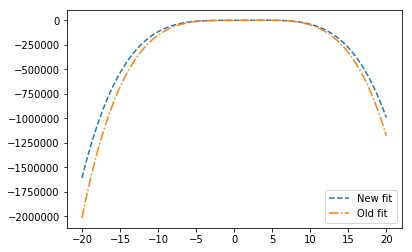

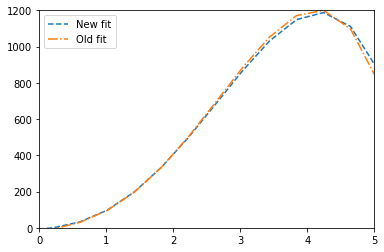

In [194]:
xvals = np.linspace(-20, 20, 100)
longfit = poly(xvals, *popt)
longold = poly(xvals, *param_old)

plt.plot(xvals, longfit, '--', label='New fit')
plt.plot(xvals, longold, '-.', label='Old fit')
plt.legend()
plt.show()

plt.plot(xvals, longfit, '--', label='New fit')
plt.plot(xvals, longold, '-.', label='Old fit')
plt.xlim(0, 5)
plt.ylim(0, 1200)
plt.legend()
plt.show()